In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [2]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from scipy import stats
from scipy import signal
from target import get_spike_counts
from Behavior.behavior import get_idxs_neuro_state, get_idxs_behav_state

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

sessions = [s for s in selected_009266.keys()]
#sessions = [s for s in selected_009265.keys()]
#sessions = [s for s in selected_008229.keys()]
sessions.sort()

try:
    sessions.remove('009266_hippoSIT_2023-04-20_15-24-14')
except:
    pass
try:
    sessions.remove('009265_hippoSIT_2023-02-27_10-18-32')
    sessions.remove('009265_hippoSIT_2023-02-27_15-33-46')
except:
    pass

# special for 009265
#sessions = sessions[7:-1]

selected = [
    '009265_hippoSIT_2023-03-09_20-03-08',
    '009265_hippoSIT_2023-03-05_11-52-17'
]
sessions

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

In [5]:
session = selected[0]
session

'009265_hippoSIT_2023-03-09_20-03-08'

In [6]:
ft = 'tSNE'
fp = 70
#ft = 'UMAP'
#fp = '0.7'
speed_thresh = 0.04  # m/s

animal = session.split('_')[0]

s_path     = os.path.join(source, animal, session)
meta_file  = os.path.join(source, animal, session, 'meta.h5')
moseq_file = os.path.join(source, animal, session, 'MoSeq.h5')
umap_file  = os.path.join(source, animal, session, 'analysis', 'W1-W4_tSNE_UMAP.h5')
units_file = os.path.join(source, animal, session, 'units.h5')
desc_file  = os.path.join(source, animal, session, 'descendants.h5')
state_file = os.path.join(source, animal, session, 'analysis', 'state_idxs.h5')
    
with h5py.File(meta_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    tgt_mx = np.array(f['processed']['target_matrix'])
    events = np.array(f['processed']['sound_events'])
with h5py.File(umap_file, 'r') as f:
    fit = np.array(f[ft][str(fp)])
with h5py.File(desc_file, 'r') as f:
    speed = np.array(f['speed'])
    hd    = np.array(f['hd'])
with h5py.File(state_file, 'r') as f:
    idxs_AL_ev = np.array(f['idxs_AL_ev'])  # bAL state
    idxs_neuro_AL_bgr_ev = np.array(f['idxs_neuro_AL_bgr_ev'])
    idxs_neuro_AL_sil_ev = np.array(f['idxs_neuro_AL_sil_ev'])
    idxs_neuro_PH_bgr_ev = np.array(f['idxs_neuro_PH_bgr_ev'])
    idxs_neuro_PH_sil_ev = np.array(f['idxs_neuro_PH_sil_ev'])
unit_names, single_units, spike_times = [], {}, {}
with h5py.File(units_file, 'r') as f:
    unit_names = [x for x in f]
with h5py.File(units_file, 'r') as f:
    for unit_name in unit_names:
        spike_times[unit_name] = np.array(f[unit_name][H5NAMES.spike_times['name']])
        single_units[unit_name] = np.array(f[unit_name][H5NAMES.inst_rate['name']])

In [7]:
# auditory state (BGR, SIL etc.) and speed filter
idxs_sta_ev = np.where(speed[events[:, 2].astype(np.int32)] < speed_thresh)[0]  # define speed filter here
idxs_run_ev = np.where(speed[events[:, 2].astype(np.int32)] > speed_thresh)[0]  # define speed filter here
idxs_bgr_ev = np.where(events[:, 1] == 1)[0]
idxs_sil_ev = np.where(events[:, 1] == 0)[0]
idxs_tgt_ev = np.where(events[:, 1] == 2)[0]
idxs_tri_ev = np.where( (events[:, 1] == 1) | (events[:, 1] == 2) )[0]  # in the trial

# separation
idxs_AL_bgr_ev  = np.intersect1d(idxs_AL_ev, idxs_bgr_ev)
idxs_AL_tgt_ev  = np.intersect1d(idxs_AL_ev, idxs_tgt_ev)
idxs_AL_sil_ev  = np.intersect1d(idxs_AL_ev, idxs_sil_ev)

idxs_PH_ev = np.array([x for x in range(len(events)) if not x in idxs_AL_ev])
idxs_PH_bgr_ev = np.intersect1d(idxs_PH_ev, idxs_bgr_ev)
idxs_PH_sil_ev = np.intersect1d(idxs_PH_ev, idxs_sil_ev)

idxs_AL_bgr_sta_ev = np.intersect1d(idxs_AL_bgr_ev, idxs_sta_ev)
idxs_PH_bgr_sta_ev = np.intersect1d(idxs_PH_bgr_ev, idxs_sta_ev)
idxs_AL_sil_sta_ev = np.intersect1d(idxs_AL_sil_ev, idxs_sta_ev)
idxs_PH_sil_sta_ev = np.intersect1d(idxs_PH_sil_ev, idxs_sta_ev)

idxs_PH_bgr_run_ev = np.intersect1d(idxs_PH_bgr_ev, idxs_run_ev)
idxs_PH_sil_run_ev = np.intersect1d(idxs_PH_sil_ev, idxs_run_ev)

# ------- computing AL / PH from neural state - for cross-session stats
# idxs_neuro_AL_b_ev = get_idxs_neuro_state(source, session, idxs_AL_bgr_sta_ev)  # basically for BGR / TGT, when sound is ON
# idxs_neuro_AL_bgr_ev = np.intersect1d(idxs_neuro_AL_b_ev, idxs_bgr_ev)  # ??
# idxs_neuro_AL_bgr_sta_ev = np.intersect1d(idxs_neuro_AL_bgr_ev, idxs_sta_ev)
# idxs_neuro_AL_s_ev = get_idxs_neuro_state(source, session, idxs_AL_sil_sta_ev)  # basically for BGR / TGT, when sound is ON
# idxs_neuro_AL_sil_ev = np.intersect1d(idxs_neuro_AL_s_ev, idxs_sil_ev)  # ??
# idxs_neuro_AL_sil_sta_ev = np.intersect1d(idxs_neuro_AL_sil_ev, idxs_sta_ev)

# # PH would be all not AL in BGR / TGT
# idxs_neuro_PH_bgr_ev = np.array([x for x in np.arange(len(events)) if not x in idxs_neuro_AL_b_ev])
# idxs_neuro_PH_bgr_ev = np.intersect1d(idxs_neuro_PH_bgr_ev, idxs_bgr_ev)
# idxs_neuro_PH_bgr_sta_ev = np.intersect1d(idxs_neuro_PH_bgr_ev, idxs_sta_ev)
# idxs_neuro_PH_sil_ev = np.array([x for x in np.arange(len(events)) if not x in idxs_neuro_AL_s_ev])
# idxs_neuro_PH_sil_ev = np.intersect1d(idxs_neuro_PH_sil_ev, idxs_sil_ev)
# idxs_neuro_PH_sil_sta_ev = np.intersect1d(idxs_neuro_PH_sil_ev, idxs_sta_ev)

print('AL / PH BGR', len(idxs_AL_bgr_sta_ev), len(idxs_PH_bgr_sta_ev))
print('AL / PH SIL', len(idxs_AL_sil_sta_ev), len(idxs_PH_sil_sta_ev))
print('STA / RUN PH BGR', len(idxs_PH_bgr_sta_ev), len(idxs_PH_bgr_run_ev))
print('STA / RUN PH SIL', len(idxs_PH_sil_sta_ev), len(idxs_PH_sil_run_ev))


AL / PH BGR 1003 1327
AL / PH SIL 296 482
STA / RUN PH BGR 1327 2607
STA / RUN PH SIL 482 1714


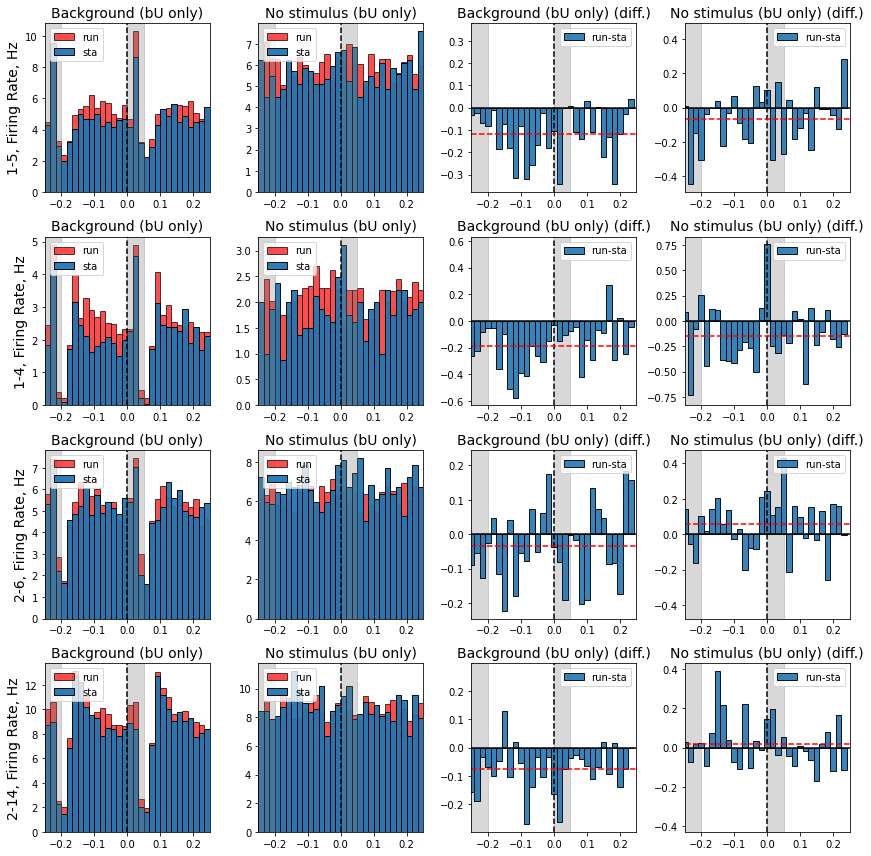

In [19]:
plot_state = False
to_plot = [name for name in unit_names if int(name[0]) < 3][:]
#to_plot = ['2-5', '2-6', '2-14', '2-15']
#to_plot = ['2-10', '2-14']  # for '009266_hippoSIT_2023-05-04_19-47-15', also '2-5'
#to_plot = ['2-5', '2-13', '2-14']  # for '009266_hippoSIT_2023-04-18_10-10-37'
#to_plot = ['1-5', '2-6', '2-14']  # for '009265_hippoSIT_2023-03-09_20-03-08'
to_plot = ['1-5', '1-4', '2-6', '2-14']  # for '009265_hippoSIT_2023-03-09_20-03-08'

hw, bc = 0.25, 31
cols = 4
rows = len(to_plot)
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))

if plot_state:  # config to plot Al / Ph state dependent
    states = [
        [idxs_AL_bgr_sta_ev, idxs_PH_bgr_sta_ev],
        [idxs_AL_sil_sta_ev, idxs_PH_sil_sta_ev]
    ]
    colors = [['tab:blue', 'navy'], ['black', 'gray']]
    labels = ['bE', 'bU']
    titles = ['Background', 'No stimulus']
else:      # STA / RUN
    states = [
        [idxs_PH_bgr_sta_ev, idxs_PH_bgr_run_ev],
        [idxs_PH_sil_sta_ev, idxs_PH_sil_run_ev]
    ]
    colors = [['tab:blue', 'red'], ['tab:blue', 'red']]
    labels = ['sta', 'run']
    titles = ['Background (bU only)', 'No stimulus (bU only)']
    
for i, unit_name in enumerate(to_plot[:]):
    deltas = []
    for j, idxs_pair in enumerate(states):
        bins, counts_A = get_spike_counts(spike_times[unit_name], events[idxs_pair[0]][:, 0], hw, bc)
        bins, counts_B = get_spike_counts(spike_times[unit_name], events[idxs_pair[1]][:, 0], hw, bc)
        deltas.append( (counts_A - counts_B)/ (0.5*(counts_B + counts_A)).mean() )

        ax = axes[i][j]
        ax.hist(bins[:-1], bins=bins, weights=counts_B, edgecolor='black', color=colors[j][1], alpha=0.7, label=labels[1])
        ax.hist(bins[:-1], bins=bins, weights=counts_A, edgecolor='black', color=colors[j][0], alpha=0.95, label=labels[0])
        ax.axvline(0, color='black', ls='--')
        ax.axvspan(0, 0.05, alpha=0.3, color='gray')
        ax.axvspan(0 - hw, 0 - hw + 0.05, alpha=0.3, color='gray')
        ax.set_title(titles[j], fontsize=14)
        ax.legend(loc='upper left', prop={'size': 10})
        ax.set_xlim(-hw, hw)
        if j == 0:
            ax.set_ylabel("%s, Firing Rate, Hz" % unit_name, fontsize=14)
            
    for j, delta in enumerate(deltas):
        d_max = np.abs(delta).max()
        ax = axes[i][j+2]
        ax.axvline(0, color='black', ls='--')
        ax.axhline(0, color='black', ls='-')
        ax.axvspan(0, 0.05, alpha=0.3, color='gray')
        ax.axvspan(0 - hw, 0 - hw + 0.05, alpha=0.3, color='gray')
        ax.bar(bins[:-1], delta, width=0.1/6, edgecolor='black', alpha=0.9, color='tab:blue', label='%s-%s' % (labels[1], labels[0]))
        ax.legend(loc='upper right', prop={'size': 10})
        ax.set_ylim(-d_max*1.1, d_max*1.1)
        ax.set_xlim(-hw, hw)
        ax.axhline(delta.mean(), color='red', ls='--')
        ax.set_title("%s (diff.)" % titles[j], fontsize=14)
        
fig.tight_layout()

In [20]:
#fig.savefig(os.path.join(report, 'showroom', 'single_units_bU_bE_%s.png' % animal), dpi=300)
fig.savefig(os.path.join(report, 'showroom', 'single_units_bU_run_sta_%s.png' % animal), dpi=300)